# Cosmology (Phys 212) Final Project

In the following notebook, we analize an expansion to the $\Lambda$-CDM model of cosmology which includes massive neutrinos and (at least one) sterile neutrino. Throughout the notebook, comments and markdown cells will expand on what the code is doing, and why I've made the choices I've made. To practice with CLASS and emcee, and to validate some of the methods I've used here, I used the code found in my $\Lambda$-CDM notebook (also included in this github).

This project contains two parts:

1) An MCMC likelihood analysis of our expanded model on the PLANCK 2018 data (the actual assignment), where we include 3 massive neutrinos, 1 light sterile neutrinoe. Furthermore, inpsired by the (admittedly out-of-date) paper https://arxiv.org/pdf/astro-ph/9602135.pdf, we include a chemical potential for the sterile neutrino. We then fit three parameters to the model (fixing the others to the CLASS calculated/PLANCK best-fit values) - omega_b, omega_cdm, and h.

2) A toy analysis where we fit the six standard $\Lambda$-CDM parameters to MC data generated with CLASS which reflects our expanded model. This is more to sate my own curiosity, by examining what it would look like if we had these neutrinos in a way that could be seen in the CMB, and how far away reality is from that scenario.



This notebook is composed with reference to the "CLASS" reference notebooks and this source on MCMC analysis (https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial.html)

Github copilot has been used to write better comments. (I'm not sure why it's doing it, but I actually can't figure out how to disable this "feature". It is not being used to write code.)

In [5]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
import corner
import pandas as pd
import emcee
import tqdm

# Load our CMB power spectrum data.
Data has been obtained from the Planck Legacy Archive: https://pla.esac.esa.int/pla/#cosmology 

The data is the power spectrum of the CMB temperature anisotropies in terms of $D_l^{TT}$.

In [6]:

data_file = '~/physics/COM_PowerSpect_CMB-TT-full_R3.01_with_header.txt'
data = pd.read_csv(data_file, sep='\s+', comment='#')
data = data.head(2499)

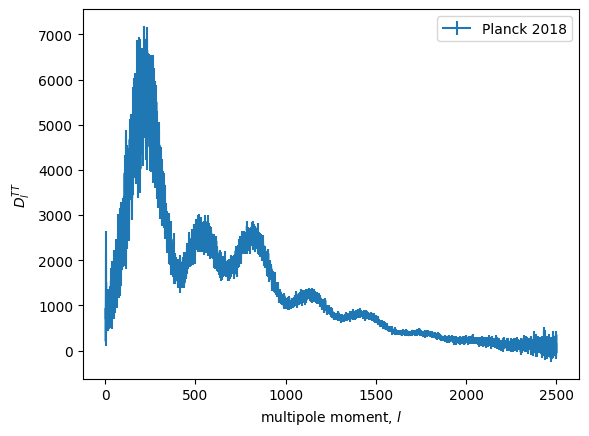

In [7]:
#Visualize the Planck 2018 data

errorbars = [data['-dDl'], data['+dDl']]
plt.errorbar(data['l'], data['Dl'], yerr = errorbars, label='Planck 2018')
plt.xlabel("multipole moment, $l$")
plt.ylabel("$D_l^{TT}$")
plt.legend()

# Define our model

Because we don't have an accessible analytical model of the CMB temperature anisotropy, we're going to use the CLASS simulator to define our model for the MCMC. 

CLASS code and documentation can be found here: https://lesgourg.github.io/class_public/class.html#documentation
The authors request the following paper be cited when the software is use in publication: https://arxiv.org/abs/1104.2933

In [22]:
# # Deprecated - couldn't support order GeV masses
# N_ur = 1.0176 # A value of 3.044 would indicate 3 massless neutrinos. We're including massive neutrinos, but including one massless neutrino here because lighter neutrino masses seem more likely (at least to me). 

# N_ncdm = 4 # Number of massive neutrinos, including sterile neutrinos

# delta_msq_21 = 7.6e-5 # Mass squared difference between the second and first neutrino mass eigenstates, in eV^2
# delta_msq_31 = 2.5e-3 # Mass squared difference between the third and first neutrino mass eigenstates, in eV^2
# # We'll assume for now the lightest neutrino is massless. We also assume the normal ordering. Values from https://www.frontiersin.org/articles/10.3389/fspas.2018.00036/full

# m_ncdm = '0.00872, 0.05, 0.5, 0.6e6'  # Masses of each of the massive neutrinos, in eV
# # We choose sterile neutrinos of 0.5 eV (the right order of magnitude active/sterile neutrino osscilations), and 0.6 GeV (one of the masses I'm considering in my dissertation research, and therefore of personal interest).

# # 5.f) 'ksi_ncdm' is the ncdm chemical potential in units of its own temperature (default: set to 0)
# ksi_ncdm = '0, 0, 0.1, 0.5' # Though out of date, this paper https://arxiv.org/pdf/astro-ph/9602135.pdf explores the interesting potential of non-zero neutrino chemical potentials (pun intended, sorry) on helping to resolve neutrino oscillation anomalies without constradicting cosmological data.

In [41]:
# Test a more standard scenario to get the code working

N_ur = 1.0176 # A value of 3.044 would indicate 3 massless neutrinos. We're including massive neutrinos, but including one massless neutrino here because lighter neutrino masses seem more likely (at least to me). 

N_ncdm = 3 # Number of massive neutrinos, including sterile neutrinos

delta_msq_21 = 7.6e-5 # Mass squared difference between the second and first neutrino mass eigenstates, in eV^2
delta_msq_31 = 2.5e-3 # Mass squared difference between the third and first neutrino mass eigenstates, in eV^2
# We'll assume for now the lightest neutrino is massless. We also assume the normal ordering. Values from https://www.frontiersin.org/articles/10.3389/fspas.2018.00036/full

m_ncdm = '0.00872, 0.05, 0.5'  # Masses of each of the massive neutrinos, in eV
# We choose a sterile neutrino of 0.5 eV (the right order of magnitude active/sterile neutrino osscilations)
# I explored the possibility of also including and HNL, but it seems like CLASS (at least as I've configured it) will only support particle masses up to the eV scale in this parameter.

# 5.f) 'ksi_ncdm' is the ncdm chemical potential in units of its own temperature (default: set to 0)
ksi_ncdm = '0, 0, 0.1' # Though out of date, this paper https://arxiv.org/pdf/astro-ph/9602135.pdf explores the interesting potential of non-zero neutrino chemical potentials (pun intended, sorry) on helping to resolve neutrino oscillation anomalies without constradicting cosmological data.

In [42]:
theta_test =  np.array([0.0223828, 0.1201075, 0.67810, np.pi*2])
get_Dls(theta_test)

array([818.64410177, 782.92400655, 747.00189988, ...,  64.61712455,
        64.44062859,  64.26310082])

In [83]:
multipole = data['l'].astype(int)
def model(theta, ells = multipole):
    '''
    Define a cosmological model we'll use to fit the PLANCK data.
    Inputs:
    theta: array of floats, model parameters
    ells: array of integers, multipole moments at which to evaluate the model (included for completion)
    Returns:
    LambdaCDM: CLASS instance, the model
    '''
    
    omega_b, omega_cdm, h, amp = theta
    #Initiate CLASS
    LambdaCDM = Class()

    # Set out (relatively exotic) model parameters (defined above):
    LambdaCDM.set({'N_ur':N_ur,'N_ncdm':N_ncdm,'m_ncdm':m_ncdm,'ksi_ncdm':ksi_ncdm})

    # pass parameters we're fitting
    LambdaCDM.set({'omega_b':omega_b,'omega_cdm':omega_cdm,'h':h})
    #Set CLASS generator settings
    LambdaCDM.set({'output':'tCl,lCl','lensing':'yes'})

    # run class - this creates our model
    LambdaCDM.compute()

    return LambdaCDM
    # get the CMB power spectrum

def get_cls(cmb_model):
    '''
    Get the CMB Temperature power spectrum from a CLASS model
    Inputs:
    cmb_model: CLASS instance, a cosmological model
    Returns:
    cls: array of floats, CMB Temperature power spectrum values
    '''
    all_cls = cmb_model.lensed_cl(2500)['tt'] #ls start at 0, so this gives cls up to l = 2500
    cls = all_cls[2:] #Our data start at l = 2
    cls_microK =cls*10**12 #Convert from K^2 to microKelvin sqaured to match Planck's units
    return cls_microK

def get_Dls(theta):
    '''
    Takes a set of cosmological parameters and returns the CMB temperature power spectrum in Dls (to match the Planck data)
    Inputs:
    theta: array of floats, model parameters
    Returns:
    Dls: array of floats, CMB temperature power spectrum values C_l*l*(l+1)/(2*pi)
    '''
    omega_b, omega_cdm, h, amp = theta
    CMB_model = model(theta)
    cls = get_cls(CMB_model)
    simulated_ls = CMB_model.lensed_cl(2500)['ell'] #ls start at 0, so this gives cls up to l = 2500
    l = simulated_ls[2:]
    Dls = amp*l*(l+1)*cls/(2*np.pi)
    return Dls

def log_likelihood(dls, x, y, yerr_up, yerr_down, amp):
    # get the model Dl for the given 'l' (passed as x). The index of each l is l-2, and l starts at 2.
    
    indeces = np.linspace(0, 2498, 2499).astype(int)
    model_y = dls[indeces]
    # calculate the likelihood
    y_err = yerr_down + yerr_up
    chi2 = np.sum((y - model_y)**2 / (y_err**2))

    ln_like = -0.5*chi2
    return ln_like

def check_priors(theta):
    # Prior ranges are inspired by the 1-sigma ranges summarized in this paper:https://www.aanda.org/articles/aa/pdf/2019/03/aa34060-18.pdf
    # I've taken the largest reported 1-sigma range for each parameter used the precision on the last digit to determine the prior (this makes them slightly assymetric in terms of amount above/below the 1 sigma interval, but I'm okay with that).
    omega_b, omega_cdm, h, amp = theta
    # LambdaCDM.set({'omega_b':0.0223828,'omega_cdm':0.1201075,'h':0.67810,'A_s':2.100549e-09,'n_s':0.9660499,'tau_reio':0.05430842})
    # if (not (omega_b/h**2 + omega_cdm/h**2) < 1):
    #     #Make sure we don't overload the total energy density
    #     return False
    if not(0.0222 < omega_b <0.0226):
        return False
    if not(0.118 < omega_cdm <0.122):
        return False
    if not(0.664 < h <0.684):
        return False
    if not (2*np.pi < amp < 3*np.pi):
        return False
    return True

def ln_prob(theta, x, y, yerr_up, yerr_down):
    omega_b, omega_cdm, h, amp = theta
    # Check if this set of parameters is allowed
    possible = check_priors(theta)
    if not possible:
        return -np.inf
    
    dls = get_Dls(theta)

    # get the likelihood
    ln_likelihood = log_likelihood(dls, x, y, yerr_up, yerr_down, amp)
    return ln_likelihood


# Set up the MCMC Sampler
This code, as well as the MCMC running function, structured absed on the MCMC tutorial cited above

In [117]:
# Set up you 'guess' for the MCMC (IE, the first theta)
theta_start = np.array([0.0224, 0.120, 0.678, np.pi*2]) #These are the values from the CLASS example, and a guess for  an amplitude conversion factor

# Set up the number of walkers and iterations for each walker
n_dim  = len(theta_start)
n_walkers = 64

# Each walker will start at a 1e-7 fluctuation from the guess, except for the amplitude parameter which has a much larger fluctuation
p0 = np.array([np.array(theta_start) + 1e-4 * np.random.randn(n_dim) for i in range(n_walkers)])
a_s = theta_start[3]
for i in range(n_walkers):
    p0[i,3] = 2.5*np.pi + 0.3*np.random.rand()

In [122]:
from multiprocessing import Pool
import cosmo_helpers as ch
def run_sampler(p0, nwalkers, niter, ndim, lnprob):
    # Define your sampler, giving it the likelihood and data

    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = (data['l'], data['Dl'], data['+dDl'], data['-dDl']), pool=pool)
        
        # Following the argument here (http://users.stat.umn.edu/~geyer/mcmc/burn.html) which I find convincing, I'm neglecting to include a burn-in sample, and instead we're starting with points near the PLANCK best-fits as defined above.
    
        print("Running production...")
        pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

In [124]:
n_iterations = 275 # This number is chosen based on how many events I can get in eight hours based on test runs.

# Run the MCMC
sampler, pos, prob, state = run_sampler(p0, n_walkers,n_iterations, n_dim, ch.ln_prob)
print(prob)

# This takes about 11 minutes for 20 iterations with ten walkers, so we'll take that into account when deciding how many to run for the analysis
# 2 iterations with 100 walkers took about 13 minutes. If so, we can do about 8 iterations/hour, so we'll run 750 iterations (with a burn sample of 50) overnight.
#With parallelization, it took about 90 seconds last time
# Oh shit I was off by a factor of ten here.

Running production...


  0%|          | 0/275 [00:00<?, ?it/s]/opt/homebrew/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
 20%|█▉        | 54/275 [1:12:20<4:46:08, 77.68s/it]

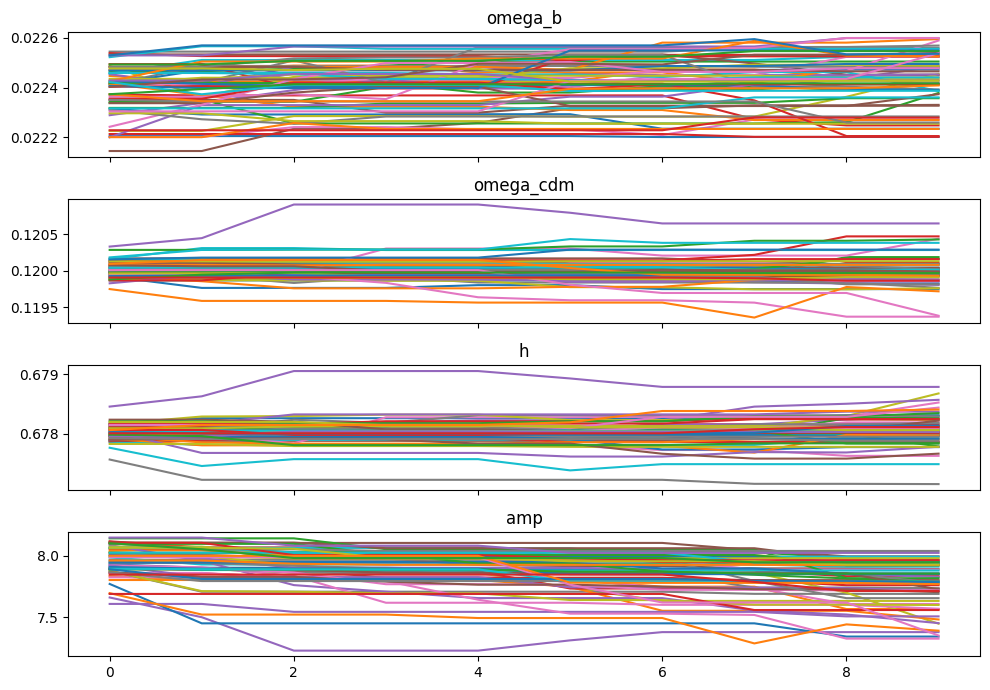

In [121]:
# make traceplots for each parameter to assess convergence - Each of our walkers is a different chain, so we can test walkers against one another.
samples = sampler.chain
n_iter = len(samples[0])

fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(10, 7), sharex=True)
for walker in sampler.chain:
    ax0.plot(walker[:,0], label='omega_b')
    ax1.plot(walker[:,1], label='omega_cdm')
    ax2.plot(walker[:,2], label='h')
    ax3.plot(walker[:,3], label='amp')
ax0.set_title('omega_b')
ax1.set_title('omega_cdm')
ax2.set_title('h')
ax3.set_title('amp')
plt.tight_layout()

In [72]:
# Plot you MCMC results

Dls = data['Dl']
ls = data['l']

def plotter(sampler,ls = ls, dls=Dls):
    plt.ion()
    plt.plot(ls, dls,label="$D_l^{TT}$")
    samples = sampler.flatchain
    for (n, theta) in enumerate(pos):
        if (prob[n] > -np.inf):
            Dls = get_Dls(theta)
            plt.plot(ls, Dls, color="r", alpha=0.1)
        #If this set of parameters isn't allowed, do nothing
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('l')
    plt.ylabel("$D_l^{TT}$")
    plt.legend()
    plt.show()

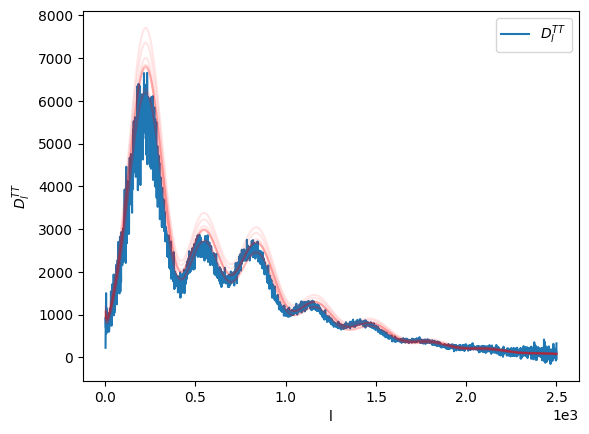

In [73]:
plotter(sampler)

In [97]:
samples = sampler.flatchain
theta_max = samples[np.argmax(sampler.flatlnprobability)]

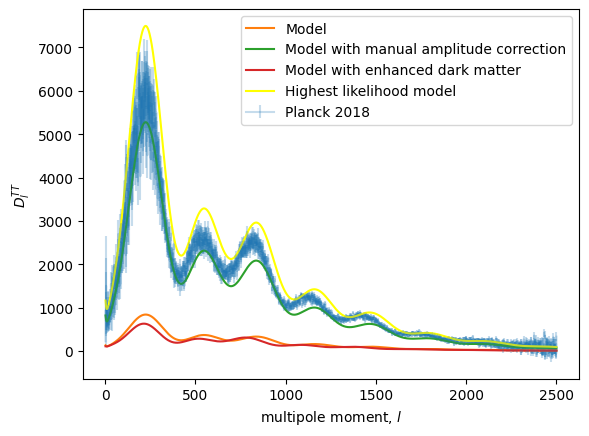

In [98]:
# Check CLASS' solution for the standard set of parameters against the PLANCK data

plt.errorbar(data['l'], data['Dl'], errorbars, label='Planck 2018', alpha=0.25)
theta_cdm = [0.0223828, 0.1201075, 0.67810, 1]
theta_cdm_amped = [0.0223828, 0.1201075, 0.67810, 2*np.pi]

dls = get_Dls(theta_cdm)#*10**12.85# We're probably missing a unit conversion here
plt.plot(ls, dls, label='Model')

dls_amped = get_Dls(theta_cdm_amped)#*10**12.85# We're probably missing a unit conversion here
plt.plot(ls, dls_amped, label='Model with manual amplitude correction')

theta_cdm_dm = [0.0223828, 0.2201075, 0.67810, 1]
dls_dm = get_Dls(theta_cdm_dm)
plt.plot(ls, dls_dm, label='Model with enhanced dark matter')
#We see from this that even though changing the DM content will raise the peaks, it will not do so significantly enough to match the data, and also results in moved peak locations.

dls_bf = get_Dls(theta_max)#*10**12.85# We're probably missing a unit conversion here
plt.plot(ls, dls_bf, label='Highest likelihood model', color='yellow', alpha=1.)

plt.xlabel("multipole moment, $l$")
plt.ylabel("$D_l^{TT}$")
plt.legend()

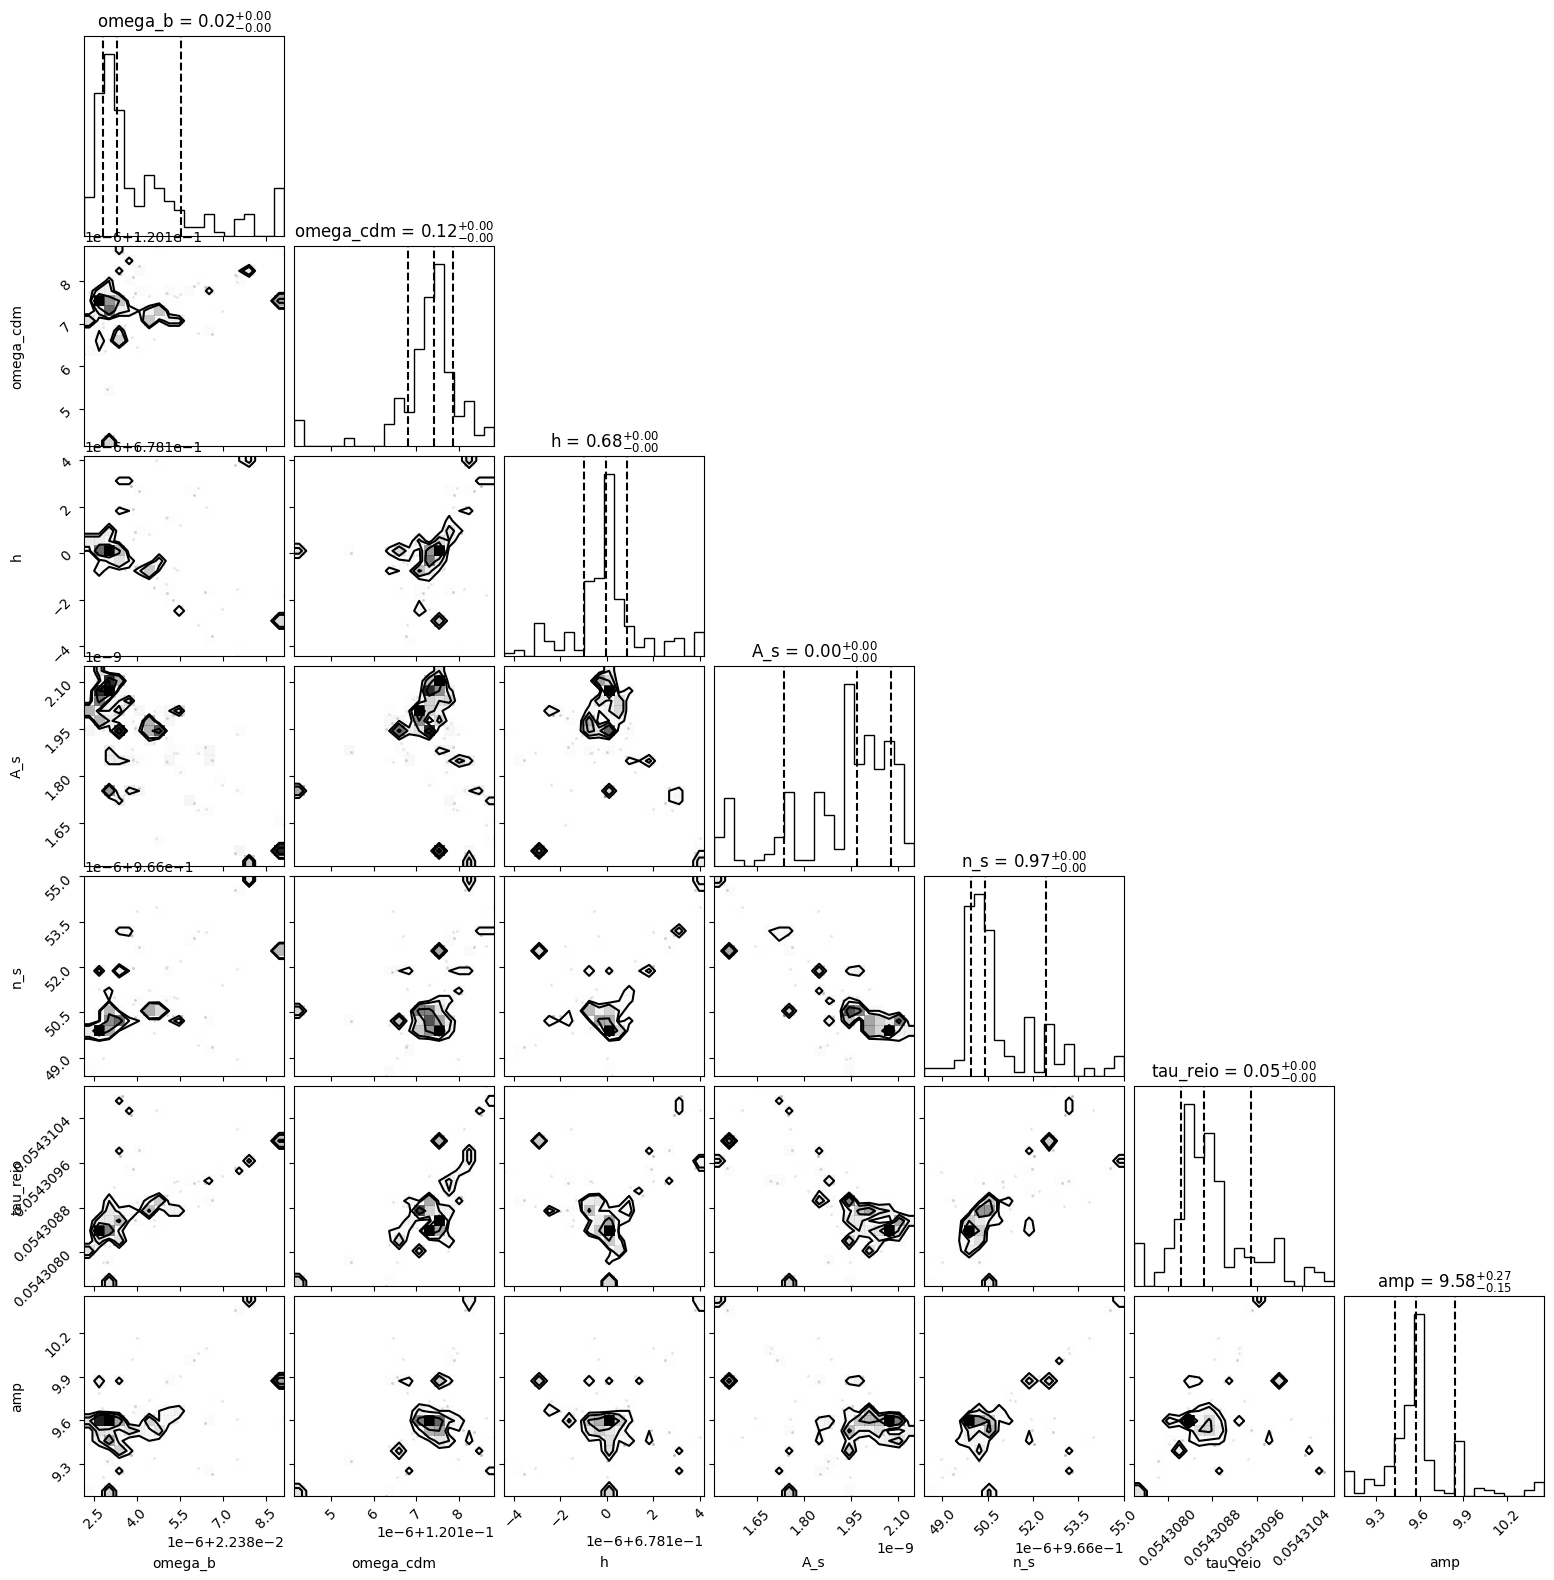

In [177]:
import corner
labels = ['omega_b', 'omega_cdm', 'h', 'A_s', 'n_s', 'tau_reio', 'amp']
fig = corner.corner(samples, show_titles=True, labels=labels, plot_datapoints = True, quantiles=[0.16, 0.5, 0.84])

# Content of the original "warmup" notebook

In [39]:
# create instance of the class "Class"
LambdaCDM = Class()
# pass input parameters
LambdaCDM.set({'omega_b':0.0223828,'omega_cdm':0.1201075,'h':0.67810,'A_s':2.100549e-09,'n_s':0.9660499,'tau_reio':0.05430842})
#LambdaCDM.set({'omega_b':2.23829144e-02,'omega_cdm':1.20107561e-01,'h':6.78100155e-01,'A_s':-1.28804382e-08,'n_s':0.9660499,'tau_reio':0.05430842})
# array([ 2.23829144e-02,  1.20107561e-01,  6.78100155e-01, -1.28804382e-08, 9.66050059e-01,  5.43084815e-02])

LambdaCDM.set({'output':'tCl,pCl,lCl,mPk','lensing':'yes','P_k_max_1/Mpc':3.0})
# run class
LambdaCDM.compute()

In [40]:
# get all C_l output
cls = LambdaCDM.lensed_cl(2500)
# To check the format of cls
cls.keys()

dict_keys(['tt', 'ee', 'te', 'bb', 'pp', 'tp', 'ell'])

In [41]:
ll = cls['ell'][2:]
clTT = cls['tt'][2:]
clEE = cls['ee'][2:]
clPP = cls['pp'][2:]

In [42]:
# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib.pyplot as plt
from math import pi

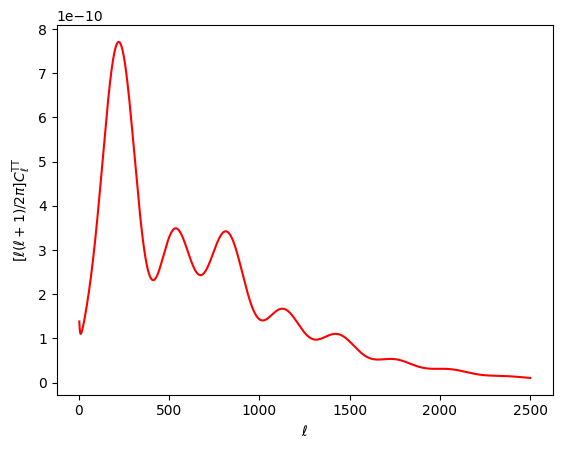

In [44]:
# plot C_l^TT
plt.figure(1)
#plt.xscale('log');plt.yscale('linear');plt.xlim(2,2500)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$[\ell(\ell+1)/2\pi]  C_\ell^\mathrm{TT}$')
plt.plot(ll,clTT*ll*(ll+1)/2./pi,'r-')

In [46]:
# get P(k) at redhsift z=0
import numpy as np
kk = np.logspace(-4,np.log10(3),1000) # k in h/Mpc
Pk = [] # P(k) in (Mpc/h)**3
h = LambdaCDM.h() # get reduced Hubble for conversions to 1/Mpc
for k in kk:
    Pk.append(LambdaCDM.pk(k*h,0.)*h**3) # function .pk(k,z)

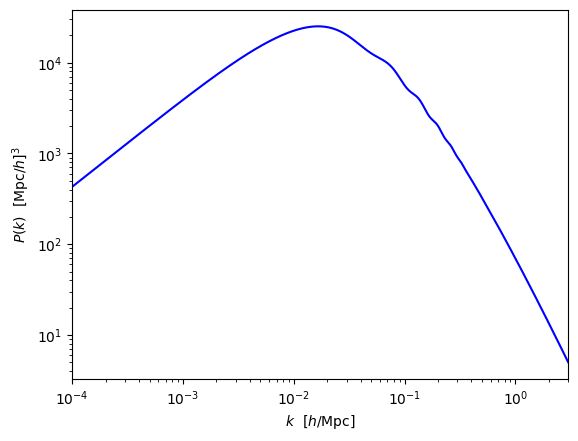

In [47]:
# plot P(k)
plt.figure(2)
plt.xscale('log');plt.yscale('log');plt.xlim(kk[0],kk[-1])
plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k) \,\,\,\, [\mathrm{Mpc}/h]^3$')
plt.plot(kk,Pk,'b-')

In [ ]:
# optional: reset parameters to default in case you want 
# to set different parameters and rerun LambdaCDM.compute()
LambdaCDM.empty()